In [2]:
from matplotlib import pyplot as plt
import matplotlib
plt.style.use('ggplot')
%matplotlib inline

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)

from triage.component.audition.distance_from_best import DistanceFromBestTable, BestDistancePlotter
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dbconfig = {'port': ,
            'host': ,
            'database': ,
            'user': ,
            'password': }

In [4]:
import sqlalchemy
conn = sqlalchemy.create_engine('postgres://', connect_args=dbconfig)

# Setting up the Auditioner instance

Currently you need to specify the set of `model_group_ids` and `train_end_times` you want to use manually, so here we're reading a few sets out of the database.

Additionally, you need to specify a name for the best distance table when creating the Auditioner and should ensure it doesn't already exist.

For simplicity, we'll just look at precision@50_abs here.

## Pre-Audition

PreAudition provids some higher level functions to obtain `model_group_ids` and `train_end_times`. For example, `get_model_groups_from_experiment()` and `get_train_end_times()`.

In [5]:
from triage.component.audition.pre_audition import PreAudition
pre_aud = PreAudition(conn)

# select model groups by experiment hash id
# model_groups = pre_aud.get_model_groups_from_experiment('f111bf3nc75n1104b37nd6fdn7b83d14')

# select model groups by label
model_groups = pre_aud.get_model_groups_from_label('final_ruling_code_1_4_5_states_klaus_fix_nulls_more_trees')

end_times = pre_aud.get_train_end_times(after='2012-01-01')

In [6]:
print(len(model_groups))
end_times

4072


[Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-09-01 00:00:00'),
 Timestamp('2014-11-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

Or you can write your own query to get the set of `model_group_ids` and `train_end_times`.

In [7]:
sel = """
SELECT DISTINCT(model_group_id)
FROM results.model_groups
WHERE model_config->>'label_definition'='final_ruling_code_1_4_5_states_klaus_fix_nulls_more_trees'
"""
model_groups = pre_aud.get_model_groups(sel)
print(len(model_groups))


4072


In [8]:
sel = """
SELECT DISTINCT train_end_time
FROM results.models
WHERE model_group_id IN ({})
    AND EXTRACT(DAY FROM train_end_time) IN (1)
    AND train_end_time >= '2012-01-01'
;
""".format(', '.join(map(str, model_groups)))

end_times = pre_aud.get_train_end_times(query=sel)
end_times

[Timestamp('2014-01-01 00:00:00'),
 Timestamp('2014-03-01 00:00:00'),
 Timestamp('2014-05-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-09-01 00:00:00'),
 Timestamp('2014-11-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-03-01 00:00:00'),
 Timestamp('2015-05-01 00:00:00'),
 Timestamp('2015-07-01 00:00:00'),
 Timestamp('2015-09-01 00:00:00'),
 Timestamp('2015-11-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-05-01 00:00:00'),
 Timestamp('2016-07-01 00:00:00')]

## Auditioner

Auditioner is the main API to do the rules selection and model groups selection. It filters model groups using a two-step process.
 - Broad thresholds to filter out truly bad models
 - A selection rule grid to find the best model groups over time for each of a variety of methods
 
For those model gorups which don't have full train_end_time periods, they will be pruned as well. 

In [9]:
from triage.component.audition import Auditioner

In [10]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups,
    train_end_times = end_times,
    initial_metric_filters = [{'metric': 'precision@', 'parameter': '50_abs', 'max_from_best': 1.0, 'threshold_value': 0.0}],
    models_table = 'models',
    distance_table = 'kr_test_dist'
)

# How to use Auditioner

## Plotting the best distance metric and groups over time

This is done with the `plot_model_groups` method and may take a minute to generate. 
What it does is to get rid of really bad model groups wrt the metric of interest. 
    A model group is discarded if:
        - It’s never close to the “best” model (define close to best) or
        - If it’s metric is below a certain number (define min threshold) at least once

/Users/Eddie/Documents/DSSG/triage/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


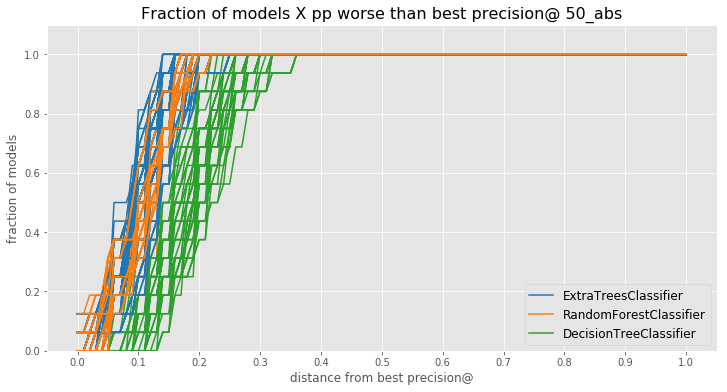

/Users/Eddie/Documents/DSSG/triage/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


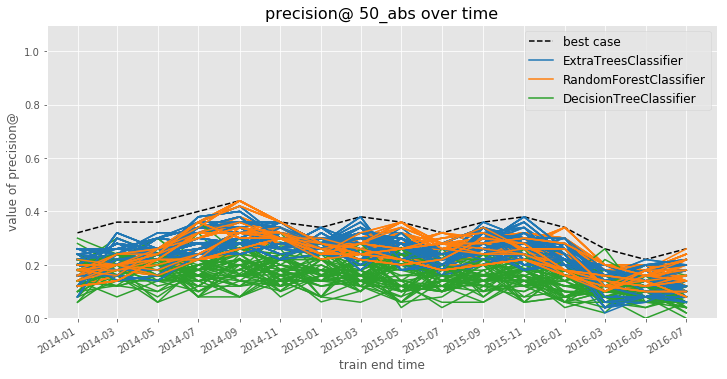

In [11]:
aud.plot_model_groups()

With our first default setting, we don't filter out models because `max_from_best`=`1.0` and `threshold_value`=`0.0` are the loosest criteria.

- The frist graph shows us the fraction of models worse than the best model by distance wrt the metric of interest.
- The second graph shows us the performance of a model group over time. The dashed line is the best case at that time period.

In [12]:
ids = aud.thresholded_model_group_ids

In [13]:
len(ids)

324

## Applying thresholds to weed out bad models

Here we use the `set_one_metric_filter` to apply a simple filter in order to eliminate poorly performing ones. The model groups will be plotted again after updating the filters.

/Users/Eddie/Documents/DSSG/triage/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


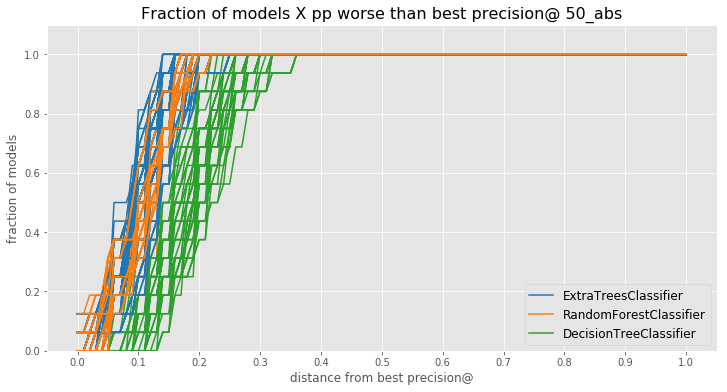

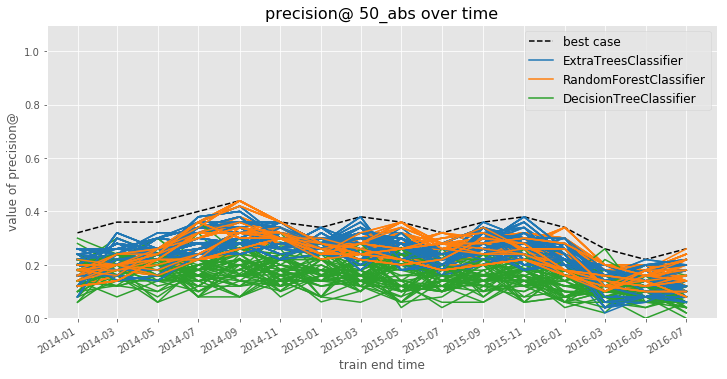

In [14]:
aud.set_one_metric_filter(
    metric='precision@', 
    parameter='50_abs', 
    max_from_best=0.5, 
    threshold_value=0.0)

Apply a round of filtering, starting with no `threshold_value` and a fairly wide margin on `max_from_best`

In [15]:
# how many model groups are left after the first round of filtering?
len(aud.thresholded_model_group_ids)

324

If that didn't thin things out too much, so let's get a bit more agressive with both parameters.
If we want to have multiple filters, then use `update_metric_filters` to apply a set of filters to the model groups we're considering in order to eliminate poorly performing ones. The model groups will be plotted again after updating the filters.

/Users/Eddie/Documents/DSSG/triage/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


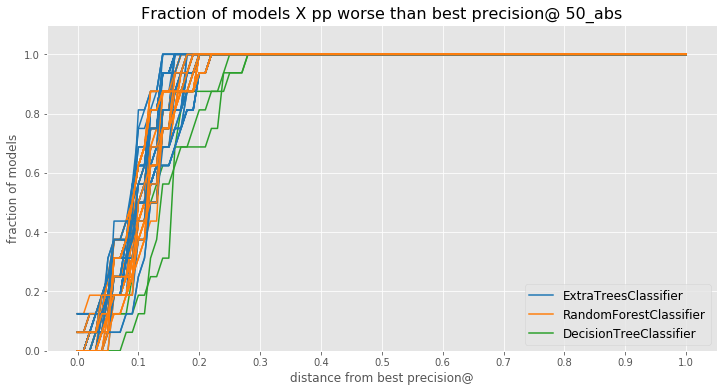

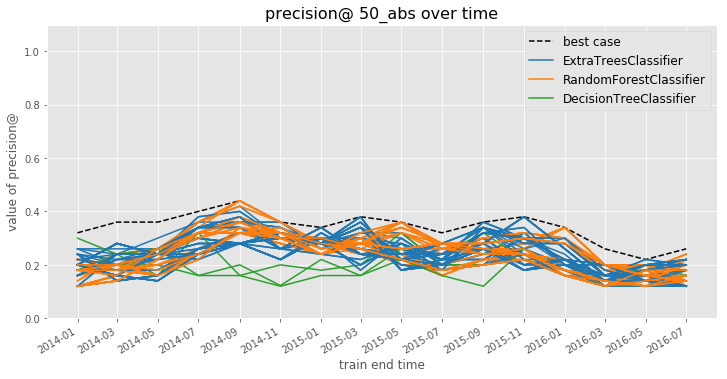

114

In [16]:
aud.update_metric_filters([{
    'metric': 'precision@', 
    'parameter': '50_abs', 
    'max_from_best': 0.5, 
    'threshold_value': 0.12
}])
len(aud.thresholded_model_group_ids)

# Applying selection rules and calculating regrets for the narrowed set of models

The goal of audition is to narrow a very large number of model groups to a small number of best candidates, ideally making use of the full time series of information. There are several ways one could consider doing so, using over-time averages of the metrics of interest, weighted averages to balance between metrics, the distance from best metrics, and balancing metric average values and stability.

Audition formalizes this idea through "selection rules" that take in the data up to a given point in time, apply some rule to choose a model group, and evaluate the performance of that chosen model in the subsequent time window, the regret. You can register, evaluate, and update selection rules associated with the Auditioner object as shown below.

Audition will run similations of different model group selection rules to show users and let users asses which rule(s) is the best for their needs. Next, Audition will output numbers of best model in current time period for each model.

## Rules Maker

We need to create a selection rule grid which will be passed to `aud.register_selection_rule_grid()` to run the simulations. The selection rule grid is only recognized as a list of dictionaries of all the parameters. One can create this giant grid by hands, but Audition also provides some helper functions to create the grid easily. 

In [17]:
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

Rule1 = SimpleRuleMaker()
Rule1.add_rule_best_current_value(metric='precision@', parameter='50_abs', n=3)
Rule1.add_rule_best_average_value(metric='precision@', parameter='50_abs', n=3)
Rule1.add_rule_lowest_metric_variance(metric='precision@', parameter='50_abs', n=3)
Rule1.add_rule_most_frequent_best_dist(metric='precision@', parameter='50_abs', dist_from_best_case=[0.05], n=3)

Rule2 = RandomGroupRuleMaker(n=1)

seln_rules = create_selection_grid(Rule1, Rule2)
seln_rules

[{'selection_rules': [{'n': 3, 'name': 'best_current_value'},
   {'n': 3, 'name': 'best_average_value'},
   {'n': 3, 'name': 'lowest_metric_variance'},
   {'dist_from_best_case': [0.05], 'n': 3, 'name': 'most_frequent_best_dist'}],
  'shared_parameters': [{'metric': 'precision@', 'parameter': '50_abs'}]},
 {'selection_rules': [{'n': 1, 'name': 'random_model_group'}],
  'shared_parameters': [{}]}]

Or we can create this grid from scratch which will give us the same output.

In [18]:
seln_rules = [{
        'shared_parameters': [
            {'metric': 'precision@', 'parameter': '50_abs'},
        ],
        'selection_rules': [
            {'name': 'best_current_value', 'n': 3},
            {'name': 'best_average_value', 'n': 3},
            {'name': 'lowest_metric_variance', 'n': 3},
            {'name': 'most_frequent_best_dist', 'dist_from_best_case': [0.05], 'n': 3}
        ]
    },
    {
        'shared_parameters': [{}],
        'selection_rules': [{'name': 'random_model_group', 'n': 1}]
    }]

Another example of the selection rules

In [ ]:
# seln_rules = [{
#         'shared_parameters': [
#             {'metric': 'precision@', 'parameter': '200_abs'},
#         ],
#         'selection_rules': [
#             {'name': 'best_current_value', 'n': 1},
#             {'name': 'best_average_value', 'n': 1},
#             {'name': 'most_frequent_best_dist', 'dist_from_best_case': [0.01, 0.05, 0.1, 0.15]}
#         ]
#     },
#     {
#         'shared_parameters': [
#             {'metric': 'precision@', 'parameter': '200_abs'}
#         ],
#         'selection_rules': [
#             {'name': 'best_avg_recency_weight', 'curr_weight': [1.5, 2.0, 5.0], 'decay_type': ['linear']}
#         ]
#     },
#     {
#         'shared_parameters': [{}],
#         'selection_rules': [{'name': 'random_model_group'}]
#     }]

## Register rules and run the simulations

Register the rules to Audition and it will run the simulations of `regret` and `metric_next_time` for every time period with all the rules and parameters combinations.

/Users/Eddie/Documents/DSSG/triage/venv/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The Vega10 colormap was deprecated in version 2.0. Use tab10 instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


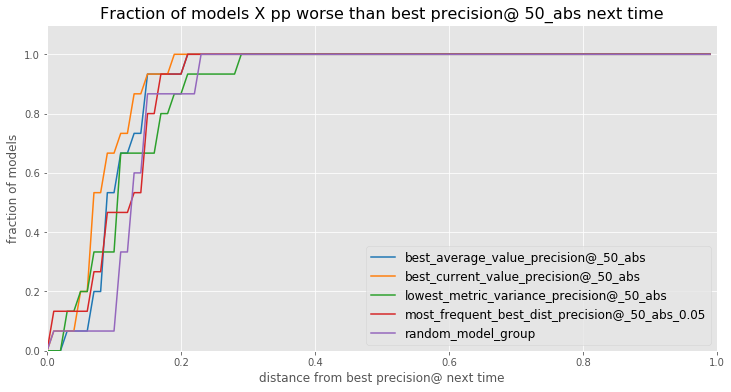

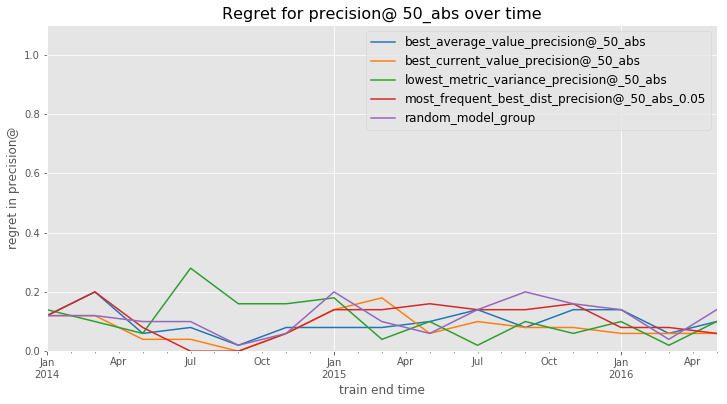

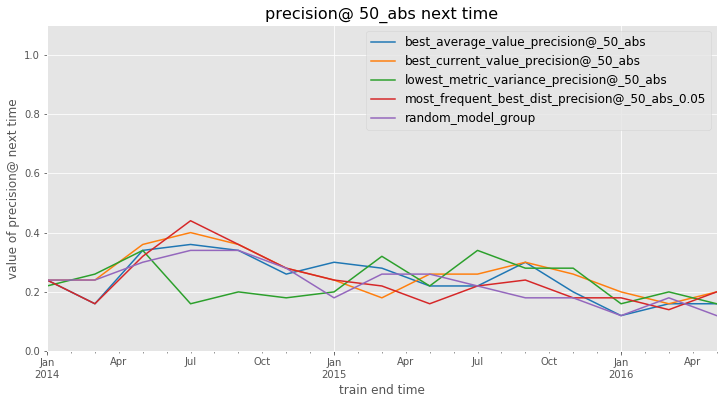

In [19]:
aud.register_selection_rule_grid(seln_rules, plot=True)

We can pull the `results_for_rule` out which is a DataFrame of simulation data. 

In [20]:
aud.results_for_rule['precision@50_abs'].head()

,model_group_id,raw_value_next_time,regret,selection_rule,train_end_time
0,270,0.24,0.12,best_current_value_precision@_50_abs,2014-01-01
1,2901,0.24,0.12,best_current_value_precision@_50_abs,2014-03-01
2,246,0.36,0.04,best_current_value_precision@_50_abs,2014-05-01
3,238,0.40,0.04,best_current_value_precision@_50_abs,2014-07-01
4,197,0.36,0.00,best_current_value_precision@_50_abs,2014-09-01


Finally, when you have a selection rule grid you're happy with, the selection_rule_model_group_ids parameter of the Auditioner will give you the model groups chosen by the selection rules in the grid when applied to the most recent end time for use in application:

In [21]:
aud.selection_rule_model_group_ids

{'best_average_value_precision@_50_abs': [246, 232, 239],
 'best_current_value_precision@_50_abs': [201, 206, 317],
 'lowest_metric_variance_precision@_50_abs': [268, 2756, 2795],
 'most_frequent_best_dist_precision@_50_abs_0.05': [237, 238, 197],
 'random_model_group': [254]}